# House Price Regression 

This notebook provides a regression approach to estimate house prices according to its features. Neural network model will be implemented here. The steps covered in this notebook are data cleansing, modelling, and out-of-sample forecast that will be submitted. 

## 1. Libraries

In [1]:
import os
import xgboost
import datetime
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 100
pd.options.display.max_columns = 9999

## 2. Dataset

In [2]:
# Locate Files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

## 3. Initial Data Exploration

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print("Data shape :",np.shape(train))
print("Unique ID :",len(train.Id.unique()))
dfnull = pd.DataFrame(train.isnull().sum()).reset_index()
dfnull.columns = ["feature","nullcount"]
dfnull["percentage"] = dfnull.nullcount * 100 / len(train)
dfnull["imputation"] = np.where(
    dfnull["percentage"] > 30, "Exclude",
    np.where(
        dfnull["percentage"] == 0, "None", "Impute"
    )
)
dfnull = dfnull.sort_values("percentage",ascending = False).reset_index(drop=True)
dfnull

Data shape : (1460, 81)
Unique ID : 1460


,feature,nullcount,percentage,imputation
0,PoolQC,1453,99.520548,Exclude
1,MiscFeature,1406,96.301370,Exclude
2,Alley,1369,93.767123,Exclude
3,Fence,1179,80.753425,Exclude
4,FireplaceQu,690,47.260274,Exclude
5,LotFrontage,259,17.739726,Impute
6,GarageYrBlt,81,5.547945,Impute
7,GarageCond,81,5.547945,Impute
8,GarageType,81,5.547945,Impute
9,GarageFinish,81,5.547945,Impute


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 4. Data Cleansing 
- Data type adjustment 
- Data Imputation 
- Data Exclusion 
- Feature adjustment

### 4.1 Data Type Adjustment 

In [7]:
df = train.copy()

### 4.2 Data Imputation 

In [8]:
df["LotFrontage"][df["LotFrontage"].isnull() == True] = 0
df["GarageYrBlt"][df["GarageYrBlt"].isnull() == True] = df["YearBuilt"]
df["GarageCond"][df["GarageCond"].isnull() == True] = "NA"
df["GarageType"][df["GarageType"].isnull() == True] = "NA"
df["GarageFinish"][df["GarageFinish"].isnull() == True] = "NA"
df["GarageQual"][df["GarageQual"].isnull() == True] = "NA"
df["BsmtFinType2"][df["BsmtFinType2"].isnull() == True] = "NA"
df["BsmtExposure"][df["BsmtExposure"].isnull() == True] = "NA"
df["BsmtQual"][df["BsmtQual"].isnull() == True] = "NA"
df["BsmtCond"][df["BsmtCond"].isnull() == True] = "NA"
df["BsmtFinType1"][df["BsmtFinType1"].isnull() == True] = "NA"
df["MasVnrArea"][df["MasVnrArea"].isnull() == True] = 0
df["MasVnrType"][df["MasVnrType"].isnull() == True] = "None"
df["Electrical"][df["Electrical"].isnull() == True] = "SBrkr"

### 4.3 Data Exclusion 

In [9]:
df = df[dfnull[dfnull.imputation != "Exclude"].feature]
dfnull = pd.DataFrame(df.isnull().sum()).reset_index()
dfnull.columns = ["feature","nullcount"]
dfnull["percentage"] = dfnull.nullcount * 100 / len(df)
dfnull["imputation"] = np.where(
    dfnull["percentage"] > 30, "Exclude",
    np.where(
        dfnull["percentage"] == 0, "None", "Impute"
    )
)
dfnull = dfnull.sort_values("percentage",ascending = False).reset_index(drop=True)
dfnull

,feature,nullcount,percentage,imputation
0,LotFrontage,0,0.0,None
1,Neighborhood,0,0.0,None
2,LotArea,0,0.0,None
3,Street,0,0.0,None
4,LotShape,0,0.0,None
5,LandContour,0,0.0,None
6,Utilities,0,0.0,None
7,YearBuilt,0,0.0,None
8,LotConfig,0,0.0,None
9,Condition1,0,0.0,None


### 4.4 Feature Adjustment

In [10]:
def onehotenc(df, col):
    add_df = pd.get_dummies(df["{}".format(col)], prefix = "{}".format(col))
    df = pd.concat([df,add_df],axis = 1)
    df = df.drop(col,axis=1)
    return df

def scale_converter_1(df,col):
    colname = "{}_inscale".format(col)
    df[colname] = 5
    df[colname][df[col] == "Ex"] = 1
    df[colname][df[col] == "Gd"] = 2
    df[colname][df[col] == "TA"] = 3
    df[colname][df[col] == "Fa"] = 4
    df[colname][df[col] == "Po"] = 5
    df[colname][df[col] == "NA"] = 6
    df = df.drop(col,axis=1)
    return df
    
def scale_converter_2(df,col):
    colname = "{}_inscale".format(col)
    df[colname] = 7
    df[colname][df[col] == "GLQ"] = 1
    df[colname][df[col] == "ALQ"] = 2
    df[colname][df[col] == "BLQ"] = 3
    df[colname][df[col] == "Rec"] = 4
    df[colname][df[col] == "LwQ"] = 5
    df[colname][df[col] == "Unf"] = 6
    df[colname][df[col] == "NA"] = 7
    df = df.drop(col,axis=1)
    return df

In [11]:
today = datetime.datetime(2017,1,1)
scale_feature1 = ["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","HeatingQC","KitchenQual","GarageQual","GarageCond","PoolQC"]
scale_feature2 = ["BsmtFinType2","BsmtFinType1"]
dfa = df.copy()
for col in df.columns :
    if dfa[col].dtype == "object":
        if col in scale_feature1:
            dfa = scale_converter_1(dfa,col)
        elif col in scale_feature2:
            dfa = scale_converter_2(dfa,col)
        else :
            dfa = onehotenc(dfa,col)
dfa["GarageAge"] = today.year - dfa["GarageYrBlt"]
dfa["BuildingAge"] = today.year - dfa["YearBuilt"]
dfa["RemodAge"] = today.year - dfa["YearRemodAdd"]
dfa["MonthsSold"] = (12 * (today.year - dfa["YrSold"])) + dfa["MoSold"] 
dfa = dfa.drop("GarageYrBlt",axis=1)
dfa = dfa.drop("YearBuilt",axis=1)
dfa = dfa.drop("YrSold",axis=1)
dfa = dfa.drop("MoSold",axis=1)
dfa = dfa.drop("YearRemodAdd",axis = 1)

df = dfa
df.head()

,LotFrontage,MasVnrArea,Id,Fireplaces,KitchenAbvGr,BedroomAbvGr,HalfBath,FullBath,BsmtHalfBath,TotRmsAbvGrd,GarageCars,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFullBath,LowQualFinSF,OverallQual,LotArea,OverallCond,2ndFlrSF,BsmtFinSF2,1stFlrSF,MSSubClass,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,SalePrice,GarageCond_inscale,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_inscale,BsmtFinType2_inscale,BsmtExposure_inscale,BsmtQual_inscale,BsmtCond_inscale,BsmtFinType1_inscale,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,KitchenQual_inscale,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HeatingQC_inscale,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Utilities_AllPub,Utilities_NoSeWa,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Street_Grvl,Street_Pave,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,CentralAir_N,CentralAir_Y,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,ExterCond_inscale,ExterQual_inscale,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,GarageAge,BuildingAge,RemodAge,MonthsSold
0,65.0,196.0,1,0,1,3,1,2,0,8,2,1710,548,0,61,0,0,0,0,0,1,0,7,8450,5,854,0,856,60,856,150,706,208500,3,0,1,0,0,0,0,0,0,0,1,0,3,6,5,2,3,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,

## 5. Data Exploration 

In [12]:
print("Data shape : ", df.shape)
print("Unique ID :", len(df.Id.unique()))
df.head()

Data shape :  (1460, 232)
Unique ID : 1460


,LotFrontage,MasVnrArea,Id,Fireplaces,KitchenAbvGr,BedroomAbvGr,HalfBath,FullBath,BsmtHalfBath,TotRmsAbvGrd,GarageCars,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,BsmtFullBath,LowQualFinSF,OverallQual,LotArea,OverallCond,2ndFlrSF,BsmtFinSF2,1stFlrSF,MSSubClass,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,SalePrice,GarageCond_inscale,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_inscale,BsmtFinType2_inscale,BsmtExposure_inscale,BsmtQual_inscale,BsmtCond_inscale,BsmtFinType1_inscale,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,KitchenQual_inscale,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HeatingQC_inscale,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Utilities_AllPub,Utilities_NoSeWa,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Street_Grvl,Street_Pave,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,CentralAir_N,CentralAir_Y,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,ExterCond_inscale,ExterQual_inscale,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,GarageAge,BuildingAge,RemodAge,MonthsSold
0,65.0,196.0,1,0,1,3,1,2,0,8,2,1710,548,0,61,0,0,0,0,0,1,0,7,8450,5,854,0,856,60,856,150,706,208500,3,0,1,0,0,0,0,0,0,0,1,0,3,6,5,2,3,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,

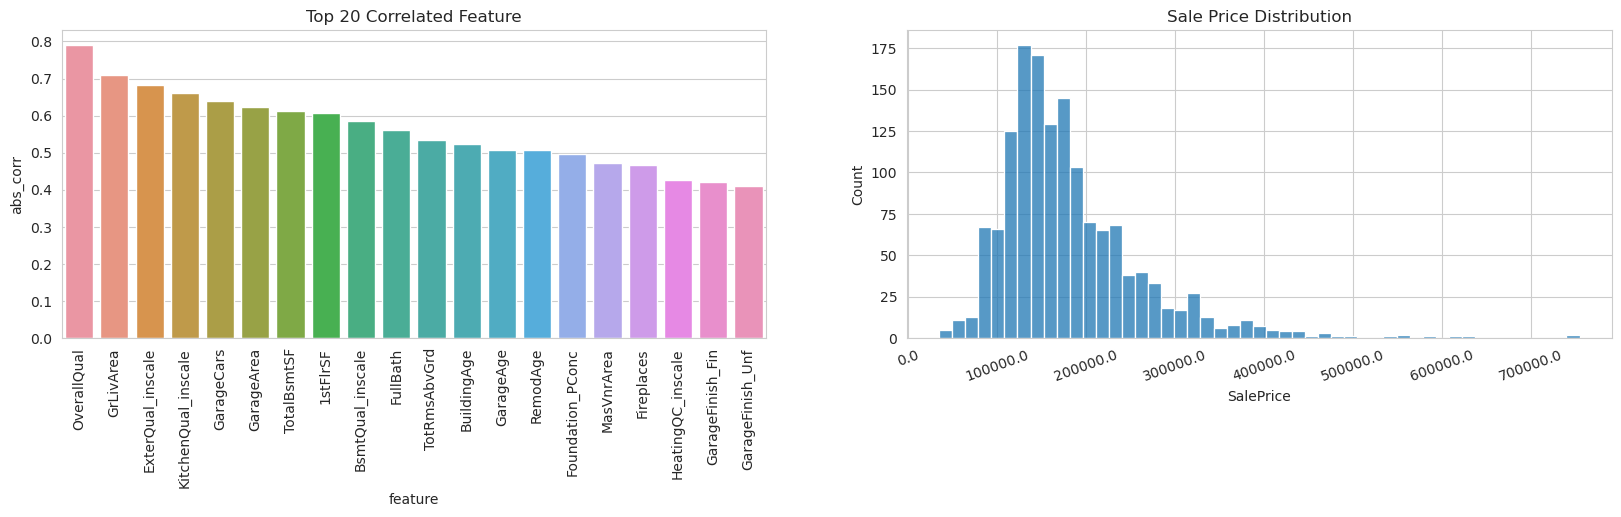

In [13]:
dfcorr = pd.DataFrame(df.corr()["SalePrice"]).reset_index()
dfcorr.columns = ["feature","corr"]
dfcorr["abs_corr"] = np.abs((dfcorr["corr"]))
dfcorr = dfcorr[dfcorr.feature != "SalePrice"]
dfcorr = dfcorr.sort_values("abs_corr",ascending = False).reset_index(drop = True)

fig, ax = plt.subplots(1,2, figsize = (20,4))
sns.barplot(x = dfcorr.iloc[0:20].feature, y = dfcorr.iloc[0:20].abs_corr, ax = ax[0])
ax[0].set_title("Top 20 Correlated Feature")
ax[0].set_xticklabels(labels = dfcorr.iloc[0:20].feature, rotation = 90 )

sns.histplot(df.SalePrice, ax = ax[1])
ax[1].set_xticklabels(labels = ax[1].get_xticks(), rotation = 20)
ax[1].set_title("Sale Price Distribution")
plt.show()

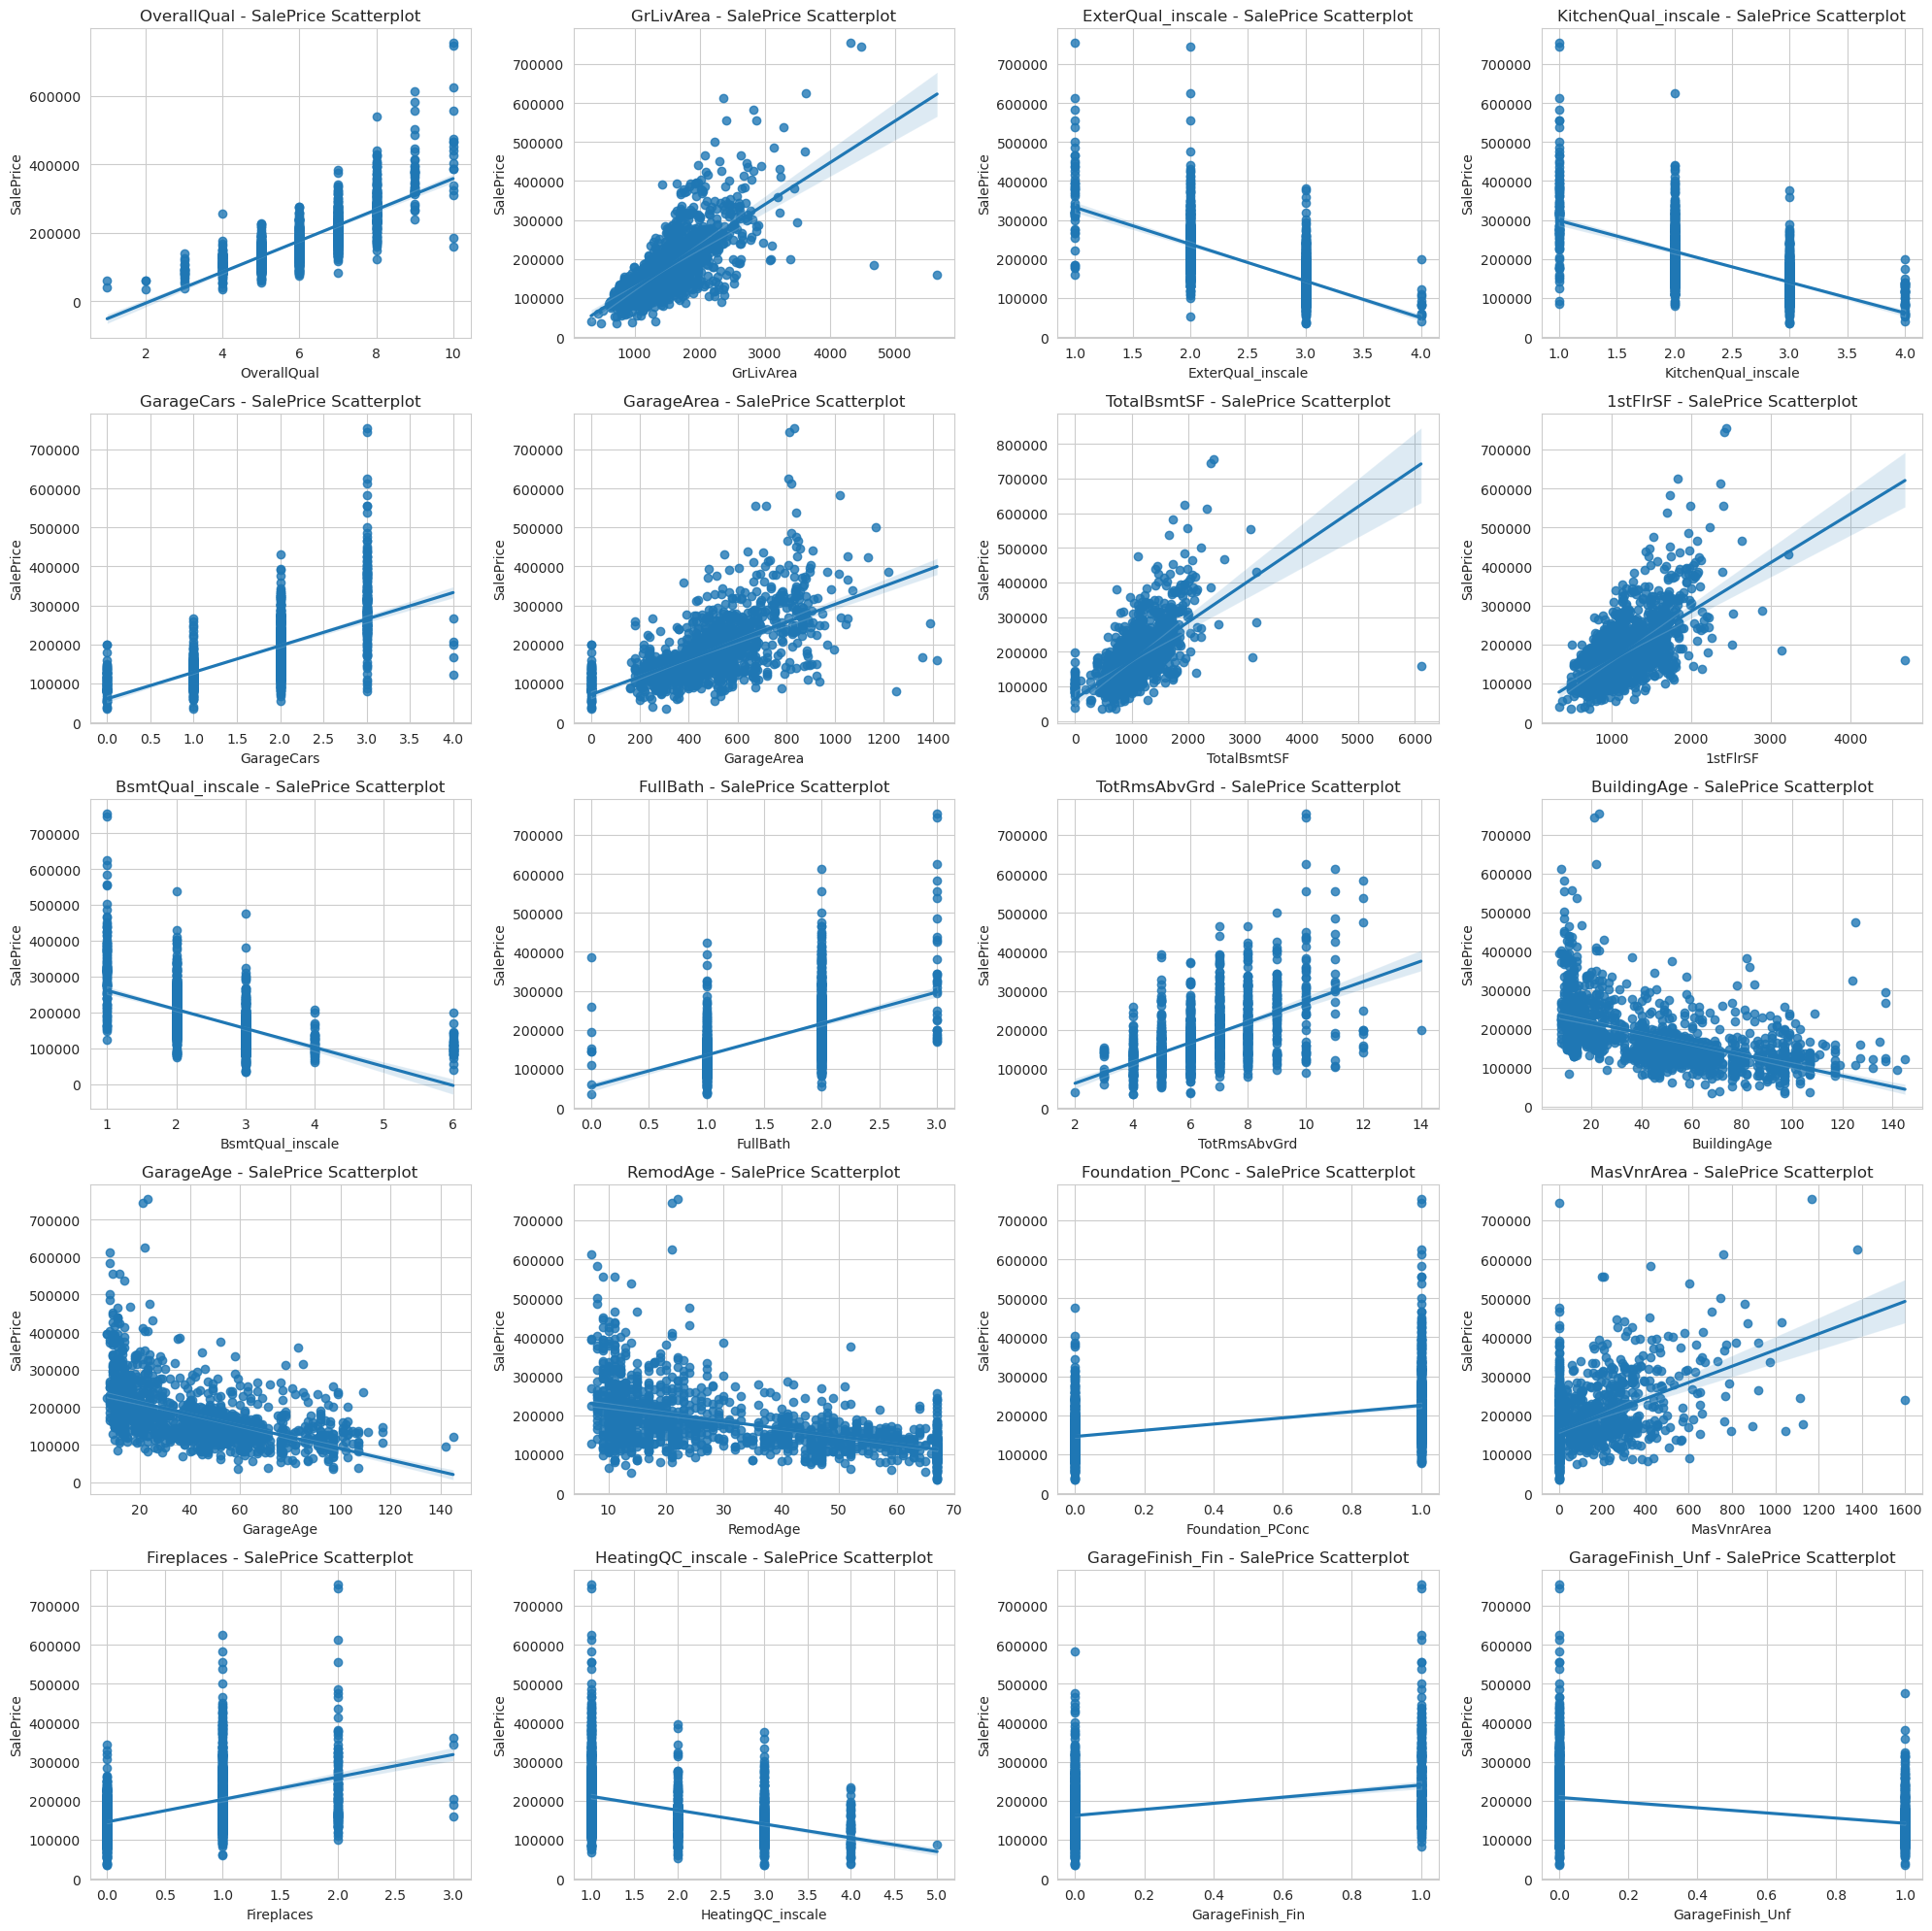

In [14]:
fig,ax = plt.subplots(5,4, figsize = (20,20))
c,r = 0,0
for col in dfcorr.iloc[0:20].feature : 
    sns.regplot(data = df, x = col, y="SalePrice", ax = ax[r,c])
    ax[r,c].set_title("{} - SalePrice Scatterplot".format(col))
    c = c+1
    if c == 4:
        r = r+1
        c = 0
fig.tight_layout()

## 6. Feature Preparation

In [15]:
fixcol = dfcorr.iloc[0:20].feature
fixcol = fixcol.tolist()
fixcol = list(set(fixcol + [col for col in df.columns if 'GarageFinish' in col] + ["SalePrice"] + ["Id"]))
dfx = df[fixcol]
X_train = dfx.drop("SalePrice",axis=1)
y_train = dfx[["SalePrice"]]
X_train.head()

,GarageFinish_Fin,GarageArea,Foundation_PConc,GrLivArea,Id,BuildingAge,1stFlrSF,MasVnrArea,BsmtQual_inscale,ExterQual_inscale,RemodAge,TotalBsmtSF,Fireplaces,TotRmsAbvGrd,OverallQual,FullBath,HeatingQC_inscale,GarageFinish_NA,GarageAge,GarageFinish_RFn,KitchenQual_inscale,GarageFinish_Unf,GarageCars
0,0,548,1,1710,1,14,856,196.0,2,2,14,856,0,8,7,2,1,0,14.0,1,2,0,2
1,0,460,0,1262,2,41,1262,0.0,2,3,41,1262,1,6,6,2,1,0,41.0,1,3,0,2
2,0,608,1,1786,3,16,920,162.0,2,2,15,920,1,6,7,2,1,0,16.0,1,2,0,2
3,0,642,0,1717,4,102,961,0.0,3,3,47,756,1,7,7,1,2,0,19.0,0,2,1,3
4,0,836,1,2198,5,17,1145,350.0,2,2,17,1145,1,9,8,2,1,0,17.0,1,2,0,3


In [16]:
y_train.head()

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000


## 7. Modelling 

In [17]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train.drop("Id",axis=1), y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 19323.414 (1876.010)


In [18]:
model.fit( X_train.drop("Id",axis=1), y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

## 8. Test Data Preparation

In [19]:
df = test.copy()
df["LotFrontage"][df["LotFrontage"].isnull() == True] = 0
df["GarageYrBlt"][df["GarageYrBlt"].isnull() == True] = df["YearBuilt"]
df["GarageCond"][df["GarageCond"].isnull() == True] = "NA"
df["GarageType"][df["GarageType"].isnull() == True] = "NA"
df["GarageFinish"][df["GarageFinish"].isnull() == True] = "NA"
df["GarageQual"][df["GarageQual"].isnull() == True] = "NA"
df["BsmtFinType2"][df["BsmtFinType2"].isnull() == True] = "NA"
df["BsmtExposure"][df["BsmtExposure"].isnull() == True] = "NA"
df["BsmtQual"][df["BsmtQual"].isnull() == True] = "NA"
df["BsmtCond"][df["BsmtCond"].isnull() == True] = "NA"
df["BsmtFinType1"][df["BsmtFinType1"].isnull() == True] = "NA"
df["MasVnrArea"][df["MasVnrArea"].isnull() == True] = 0
df["MasVnrType"][df["MasVnrType"].isnull() == True] = "None"
df["Electrical"][df["Electrical"].isnull() == True] = "SBrkr"

dfnull_test = dfnull.copy()
dfnull_test = dfnull_test[dfnull_test.feature != "SalePrice"]
df = df[dfnull_test[dfnull_test.imputation != "Exclude"].feature]

today = datetime.datetime(2017,1,1)
scale_feature1 = ["ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","HeatingQC","KitchenQual","GarageQual","GarageCond","PoolQC"]
scale_feature2 = ["BsmtFinType2","BsmtFinType1"]
dfa = df.copy()
for col in df.columns :
    if dfa[col].dtype == "object":
        if col in scale_feature1:
            dfa = scale_converter_1(dfa,col)
        elif col in scale_feature2:
            dfa = scale_converter_2(dfa,col)
        else :
            dfa = onehotenc(dfa,col)
dfa["GarageAge"] = today.year - dfa["GarageYrBlt"]
dfa["BuildingAge"] = today.year - dfa["YearBuilt"]
dfa["RemodAge"] = today.year - dfa["YearRemodAdd"]
dfa["MonthsSold"] = (12 * (today.year - dfa["YrSold"])) + dfa["MoSold"] 
dfa = dfa.drop("GarageYrBlt",axis=1)
dfa = dfa.drop("YearBuilt",axis=1)
dfa = dfa.drop("YrSold",axis=1)
dfa = dfa.drop("MoSold",axis=1)
dfa = dfa.drop("YearRemodAdd",axis = 1)

df = dfa

fixcol = dfcorr.iloc[0:20].feature
fixcol = fixcol.tolist()
fixcol = list(set(fixcol + [col for col in df.columns if 'GarageFinish' in col] + ["Id"]))
dfx = df[fixcol]
X_test = dfx
X_test.head()

,GarageFinish_Fin,GarageArea,Foundation_PConc,GrLivArea,Id,BuildingAge,1stFlrSF,MasVnrArea,BsmtQual_inscale,ExterQual_inscale,RemodAge,TotalBsmtSF,Fireplaces,TotRmsAbvGrd,OverallQual,FullBath,HeatingQC_inscale,GarageFinish_NA,GarageAge,GarageFinish_RFn,KitchenQual_inscale,GarageFinish_Unf,GarageCars
0,0,730.0,0,896,1461,56,896,0.0,3,3,56,882.0,0,5,5,1,3,0,56.0,0,3,1,1.0
1,0,312.0,0,1329,1462,59,1329,108.0,3,3,59,1329.0,0,6,6,1,3,0,59.0,0,2,1,1.0
2,1,482.0,1,1629,1463,20,928,0.0,2,3,19,928.0,1,6,5,2,2,0,20.0,0,3,0,2.0
3,1,470.0,1,1604,1464,19,926,20.0,3,3,19,926.0,1,7,6,2,1,0,19.0,0,2,0,2.0
4,0,506.0,1,1280,1465,25,1280,0.0,2,2,25,1280.0,0,5,8,2,1,0,25.0,1,2,0,2.0


## 9. Prediction

In [20]:
yhat = model.predict(X_test.drop("Id",axis=1))
X_test["SalePrice"] = yhat

In [21]:
X_test[["Id","SalePrice"]]

,Id,SalePrice
0,1461,136199.375000
1,1462,146157.031250
2,1463,175203.046875
3,1464,180543.546875
4,1465,197376.109375
...,...,...
1454,2915,83873.726562
1455,2916,84560.593750
1456,2917,151499.187500
1457,2918,101666.531250


In [22]:
X_test[["Id","SalePrice"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB


In [23]:
sample_submission["SalePrice"] = yhat
sample_submission.to_csv("submission.csv", index = False)